In [1]:
from minisom import MiniSom
from sklearn_som.som import SOM
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import warnings
import re
import string

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rao.ans/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/rao.ans/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/rao.ans/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/rao.ans/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("../../data/user_info/popular_tweets.csv.gz")

In [5]:
df.head()

,text,created_at,bear_bull_tag,user_name,user_id,message_id,ticker
0,$AB | AllianceBernstein Q4 21 Earnings: \nAdj ...,2022-02-11T11:27:18Z,NaN,LiveSquawk,130351,435511902,AB
1,"Nancy Pelosi Buys Tesla Calls, Stands To Benef...",2021-01-26T19:33:19Z,NaN,Benzinga,7108,277882388,AB
2,3 Big Dividend Stocks Yielding 7% — or More; E...,2020-09-28T13:45:47Z,NaN,TipRanks,217593,246681035,AB
3,Value Investing Is Alive And Well: 5 Picks. $S...,2020-08-11T21:23:36Z,NaN,ZacksResearch,82492,235582933,AB
4,$AB stalking as a potential swing long above 2...,2020-06-18T16:30:28Z,Bullish,ACInvestorBlog,2503,221060450,AB


In [6]:
def clean_text(txt):
    """
    Clean text in the dataset.
    
    :param txt: txt string that is present in the input file.
    :type  txt: str
    :return: string that has been cleaned using Wordnet Lemmatizer, etc. 
    :rtype: str
    """
    
    txt = txt.lower()  # convert to lowercase
    txt = re.sub(r'^https?:\/\/.*[\s]*', '', txt)  # remove links
    words = txt.split(" ")
    # remove tickers
    words_without_tickers = []
    for w in words:
        if w.startswith("$") and len(w) > 1:
            continue
        words_without_tickers += [w]
    non_ticker_text = " ".join(words_without_tickers)
    words = nltk.tokenize.word_tokenize(non_ticker_text)  # tokenize
    words = [word if word.isalpha() else '' for word in words]  # only retains words, not numbers, etc.
    lemmatizer = nltk.wordnet.WordNetLemmatizer()
    stop_words = set(nltk.corpus.stopwords.words('english')).union(set(["hey", "http", "https", 
                                                                        "u", "im", "amp", "pre"]))
    final_tokens = []
    for w in words:
        w = "".join(["" if c in string.punctuation else c for c in w])  # remove punctutation
        if w != "" and w not in stop_words:  # process only non stopwords
            final_tokens.append(lemmatizer.lemmatize(w))  # using WordNet for lemmatizing
    cleaned_txt = " ".join(final_tokens)
    return cleaned_txt

In [7]:
# removing bots
df = df[~df.user_name.isin(["OpenOutcrier", "briefingcom", "Estimize"])]

In [8]:
df['text'] = df['text'].apply(lambda r: clean_text(r))

### TF-IDF

In [9]:
vectorizer = TfidfVectorizer(stop_words=set(nltk.corpus.stopwords.words('english')), 
                             max_features=1000)
X = vectorizer.fit_transform(df.text)

In [10]:
feature_names = vectorizer.get_feature_names_out()

### MiniSom
https://github.com/JustGlowing/minisom

In [11]:
D = X.todense().tolist()

In [12]:
M = 3  # lattice dimension
som = MiniSom(M, M, X.shape[1])

In [13]:
som.pca_weights_init(D)
som.train(D, 40000, random_order=False, verbose=True)

 [ 40000 / 40000 ] 100% - 0:00:00 left 
 quantization error: 0.990871796064805


In [14]:
top_keywords = 10

In [15]:
weights = som.get_weights()

In [16]:
keywords = []
for i in range(M):
    for j in range(M):
        keywords_idx = np.argsort(weights[i,j,:])[-top_keywords:]
        keywords.append([feature_names[k] for k in keywords_idx])

In [17]:
colors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

In [18]:
stop_words = set(nltk.corpus.stopwords.words('english')).union(set(["hey", "http", "https", 
                                                                    "u", "im", "amp", "pre"]))
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: colors[i],
                  prefer_horizontal=1.0)

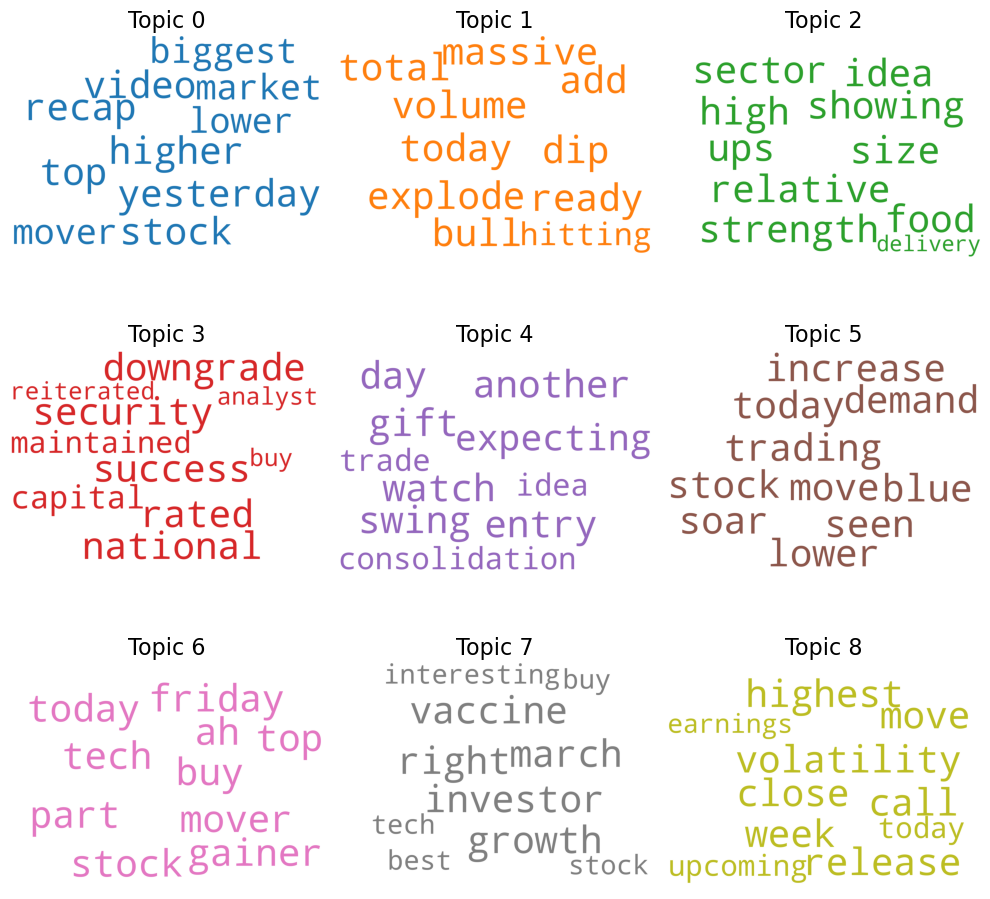

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=True)


for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict.fromkeys(keywords[i], 1)
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig('minisom_topics.png', bbox_inches='tight')
plt.show()

### 2. sklearn-som
https://github.com/rileypsmith/sklearn-som

In [20]:
som = SOM(M, M, X.shape[1])
som.fit(X.toarray())

In [21]:
weights = som.weights

In [22]:
keywords = []
for i in range(M * M):
    keywords_idx = np.argsort(weights[i])[-top_keywords:]
    keywords.append([feature_names[k] for k in keywords_idx])

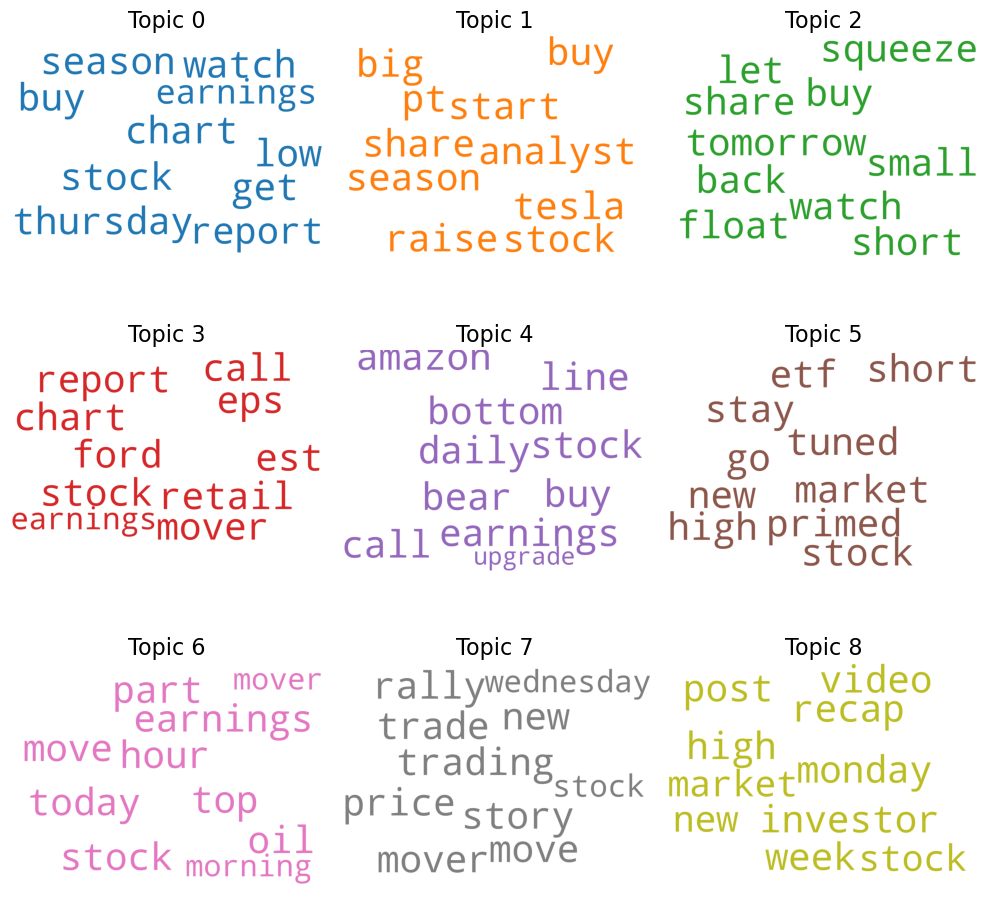

In [23]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=True)


for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict.fromkeys(keywords[i], 1)
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig('sklearn_som_topics.png', bbox_inches='tight')
plt.show()